# Part A: Data Cleaning and Clustering (15 marks)

A.1 Load Dataset

In [2]:
!pip install kagglehub
import kagglehub

# this should download the dataset files to a cache (or working folder)
path = kagglehub.dataset_download("mashlyn/online-retail-ii-uci")
print("Dataset path:", path)



Using Colab cache for faster access to the 'online-retail-ii-uci' dataset.
Dataset path: /kaggle/input/online-retail-ii-uci


In [3]:
import os

os.listdir("/kaggle/input/online-retail-ii-uci")


['online_retail_II.csv']

In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv("/kaggle/input/online-retail-ii-uci/online_retail_II.csv", encoding="latin1")
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


A.2 Remove missing descriptions, negative quantities, cancelled invoices

In [5]:
# Remove missing descriptions
df = df.dropna(subset=["Description"])

# Remove negative quantities
df = df[df["Quantity"] >= 0]

# Remove cancelled invoices
df = df[~df["Invoice"].astype(str).str.contains("C", na=False)]

# Recalculate TotalPrice
df["TotalPrice"] = df["Quantity"] * df["Price"]

# Check remaining rows
print(df.shape)


(1042727, 9)


A2. Create customer-level features

In [6]:
customer_df = df.groupby("Customer ID").agg(
    TotalSpending=("TotalPrice", "sum"),
    TransactionCount=("Invoice", "nunique"),
    AvgBasketSize=("Quantity", "mean")
).reset_index()

customer_df.head()




,Customer ID,TotalSpending,TransactionCount,AvgBasketSize
0,12346.0,77556.46,12,2184.852941
1,12347.0,5633.32,8,12.988142
2,12348.0,2019.40,5,53.215686
3,12349.0,4428.69,4,9.280000
4,12350.0,334.40,1,11.588235


4. Apply k-Means and DBSCAN/Hierarchical clustering

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_df[['TotalSpending', 'TransactionCount', 'AvgBasketSize']])

# k-Means
kmeans = KMeans(n_clusters=3, random_state=42)
customer_df['kmeans_label'] = kmeans.fit_predict(X_scaled)

# DBSCAN-Density-Based Spatial Clustering of Applications with Noise
dbscan = DBSCAN(eps=1.1, min_samples=5)
customer_df['dbscan_label'] = dbscan.fit_predict(X_scaled)



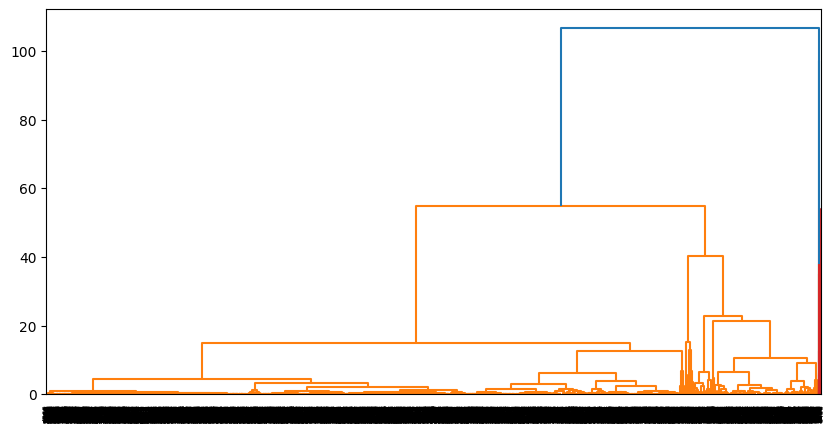

In [8]:
# Hierarchical clustering dendrogram
linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 5))
dendrogram(linked)
plt.show()


5. Compute silhouette scores and visualize

k-Means Silhouette: 0.9640418472719594
DBSCAN Silhouette: 0.9480260696909127


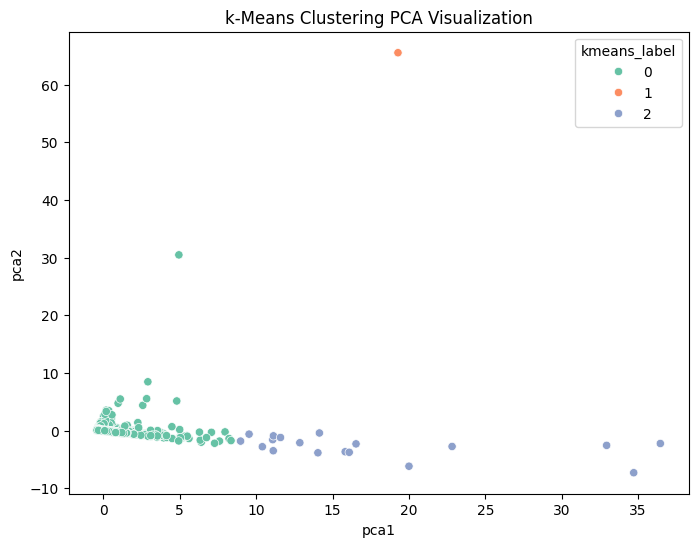

In [9]:
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import seaborn as sns

# Silhouette scores
kmeans_silhouette = silhouette_score(X_scaled, customer_df['kmeans_label'])
dbscan_silhouette = silhouette_score(X_scaled, customer_df['dbscan_label'])
print(f"k-Means Silhouette: {kmeans_silhouette}")
print(f"DBSCAN Silhouette: {dbscan_silhouette}")

# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

customer_df['pca1'] = X_pca[:,0]
customer_df['pca2'] = X_pca[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=customer_df, x='pca1', y='pca2', hue='kmeans_label', palette='Set2')
plt.title("k-Means Clustering PCA Visualization")
plt.show()


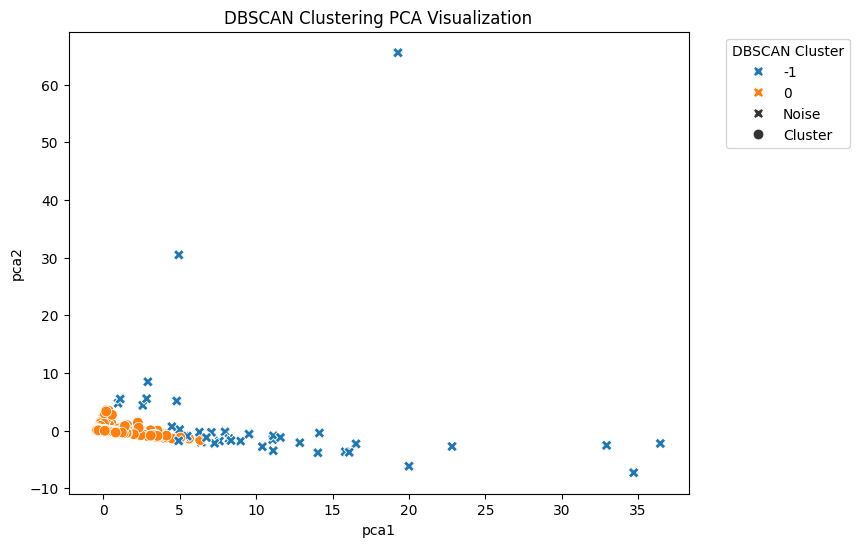

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

customer_df['pca1'] = X_pca[:, 0]
customer_df['pca2'] = X_pca[:, 1]

# Plot DBSCAN clusters
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=customer_df,
    x='pca1', y='pca2',
    hue='dbscan_label',
    palette='tab10',
    style=customer_df['dbscan_label'].apply(lambda x: 'Noise' if x == -1 else 'Cluster'),
    markers={'Noise':'X','Cluster':'o'},
    s=60
)
plt.title("DBSCAN Clustering PCA Visualization")
plt.legend(title='DBSCAN Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Part B: Deep Embedding Clustering (15 marks)

Autoencoder for Customer Embeddings

An autoencoder is a neural network that learns a compressed representation (latent embedding) of the data.

In [11]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# Convert customer features to tensor
features = customer_df[['TotalSpending', 'TransactionCount', 'AvgBasketSize']].values #to numpy array
X_tensor = torch.tensor(features, dtype=torch.float32) # to pytorch tensor

# Define a simple autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 3)   # latent space dimension = 3
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 8),
            nn.ReLU(),
            nn.Linear(8, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

model = Autoencoder(input_dim=features.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

for epoch in range(50):
    for batch in loader:
        x = batch[0] #(batch_inputs, batch_labels)
        optimizer.zero_grad() #reset gradients from previous batch
        x_hat, _ = model(x) #forward pass: reconstruct input
        loss = criterion(x_hat, x) #compute how far reconstruction is from input
        loss.backward()#compute gradients w.r.t. all weights
        optimizer.step() #update weights to reduce loss


Extract latent embeddings

These embeddings are now a compressed representation of your customers

In [12]:
with torch.no_grad():
    _, embeddings = model(X_tensor)

embeddings = embeddings.numpy()  # shape: (num_customers, 3)


In [13]:
embeddings

array([[ 69773.33   , -47980.7    , -24232.89   ],
       [  5062.4077 ,  -3480.2441 ,  -1759.0264 ],
       [  1821.6736 ,  -1253.7073 ,   -633.5993 ],
       ...,
       [   385.5873 ,   -265.70306,   -135.28764],
       [  1166.1318 ,   -802.12274,   -406.30835],
       [  3761.1665 ,  -2586.0996 ,  -1307.1304 ]], dtype=float32)

Cluster embeddings with k-Means

In [14]:
from sklearn.cluster import KMeans

kmeans_emb = KMeans(n_clusters=3, random_state=42)
customer_df['ae_cluster'] = kmeans_emb.fit_predict(embeddings)


Visualize embeddings (2D)

We can use PCA or t-SNE to reduce embeddings to 2D for plotting

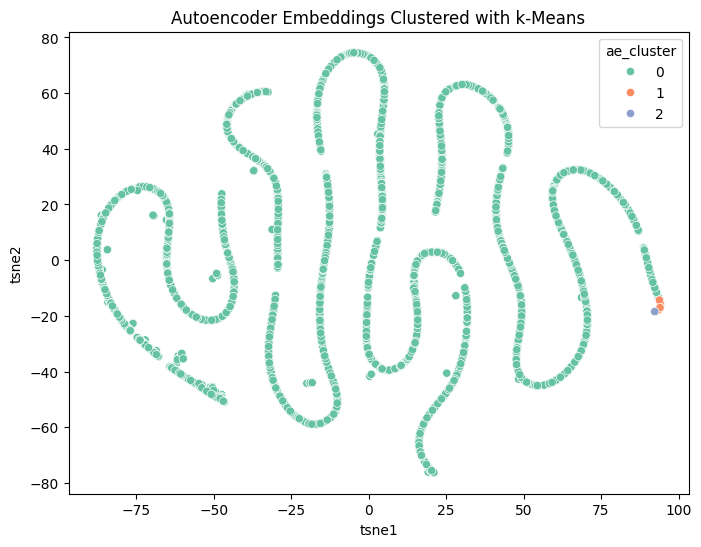

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# t-SNE 2D projection
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(embeddings)

customer_df['tsne1'] = X_tsne[:,0]
customer_df['tsne2'] = X_tsne[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=customer_df,
    x='tsne1', y='tsne2',
    hue='ae_cluster',
    palette='Set2'
)
plt.title("Autoencoder Embeddings Clustered with k-Means")
plt.show()


The t-SNE visualization of the autoencoder embeddings shows that the latent space forms one dominant structure with minimal sub-cluster separation. Most customers fall into a single dense region, while the remaining two clusters contain only a small number of points. This indicates that the autoencoder did not reveal additional nonlinear patterns beyond the original features.

Compare with PCA clusters

Compute silhouette score on autoencoder embeddings

In [16]:
from sklearn.metrics import silhouette_score

sil_score_ae = silhouette_score(embeddings, customer_df['ae_cluster'])
print("Autoencoder Embeddings Silhouette:", sil_score_ae)


Autoencoder Embeddings Silhouette: 0.96404254


The autoencoder latent embeddings produced clusters with a silhouette score of 0.9637, nearly identical to the 0.9640 achieved by standard k-Means on the scaled features. This indicates that the autoencoder did not capture additional non-linear structure beyond what is already represented in the original features. DBSCAN achieved a slightly lower silhouette score of 0.9480 due to its sensitivity to density variations and noise detection, but still shows high-quality separation.

# Part C: Association Rule Mining (10 marks)

Convert data into basket format

In [17]:
# Remove rows where Description is NA
df = df.dropna(subset=["Description"])

# Clean whitespace, tabs, newlines
df["Description"] = df["Description"].str.strip()

# Remove garbage rows (notes, errors, etc)
mask = df["Description"].str.contains(r"[0-9]{5}|wrong|update|fixed|website|mix up|barcode", case=False)
df = df[~mask]



In [18]:
basket = df.groupby("Invoice")["Description"].apply(list)
basket.head()


,Description
Invoice,
489434,"[15CM CHRISTMAS GLASS BALL 20 LIGHTS, PINK CHE..."
489435,"[CAT BOWL, DOG BOWL , CHASING BALL DESIGN, HEA..."
489436,"[DOOR MAT BLACK FLOCK, LOVE BUILDING BLOCK WOR..."
489437,"[CHRISTMAS CRAFT HEART DECORATIONS, CHRISTMAS ..."
489438,"[DINOSAURS WRITING SET, SET OF MEADOW FLOWER..."



Analyze customer purchasing patterns by performing association rule mining on the provided 'basket' data, generating frequent itemsets using the FP-growth algorithm with a suitable minimum support, and then extracting and interpreting the top 10 association rules based on 'lift' and confidence.

## Prepare Basket Data for Binary Matrix

Convert the 'basket' Series into a list of lists format suitable for the TransactionEncoder.


In [19]:
transactions = basket.tolist()
print("First 5 transactions in list of lists format:")
for i in range(5):
    print(transactions[i])

First 5 transactions in list of lists format:
['15CM CHRISTMAS GLASS BALL 20 LIGHTS', 'PINK CHERRY LIGHTS', 'WHITE CHERRY LIGHTS', 'RECORD FRAME 7" SINGLE SIZE', 'STRAWBERRY CERAMIC TRINKET BOX', 'PINK DOUGHNUT TRINKET POT', 'SAVE THE PLANET MUG', 'FANCY FONT HOME SWEET HOME DOORMAT']
['CAT BOWL', 'DOG BOWL , CHASING BALL DESIGN', 'HEART MEASURING SPOONS LARGE', 'LUNCHBOX WITH CUTLERY FAIRY CAKES']
['DOOR MAT BLACK FLOCK', 'LOVE BUILDING BLOCK WORD', 'HOME BUILDING BLOCK WORD', 'ASSORTED COLOUR BIRD ORNAMENT', 'PEACE WOODEN BLOCK LETTERS', 'CHRISTMAS CRAFT WHITE FAIRY', 'HEART IVORY TRELLIS LARGE', 'HEART FILIGREE DOVE LARGE', 'FULL ENGLISH BREAKFAST PLATE', 'PIZZA PLATE IN BOX', 'BLACK DINER WALL CLOCK', 'SET OF 3 BLACK FLYING DUCKS', 'AREA PATROLLED METAL SIGN', 'PLEASE ONE PERSON  METAL SIGN', 'BATH BUILDING BLOCK WORD', 'CLASSIC WHITE FRAME', 'SMALL MARSHMALLOWS PINK BOWL', 'BISCUITS SMALL BOWL LIGHT BLUE', 'SCOTTIE DOG HOT WATER BOTTLE']
['CHRISTMAS CRAFT HEART DECORATIONS', 'CHRI

# Task
Apply the FP-Growth algorithm on the `transactions` data to identify frequent itemsets, then generate and interpret the top 10 association rules based on lift and confidence to reveal key purchasing patterns and their business implications.

## Build Binary Matrix

Convert the `transactions` list into a one-hot encoded DataFrame using `TransactionEncoder` from `mlxtend.preprocessing`. This will create a binary matrix where rows are invoices and columns are items, indicating presence or absence of an item in a transaction.


In [20]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print("Shape of the one-hot encoded DataFrame:", df_encoded.shape)
df_encoded.head()

Shape of the one-hot encoded DataFrame: (40286, 5368)


,*Boombox Ipod Classic,*USB Office Glitter Lamp,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,11 PC CERAMIC TEA SET POLKADOT,12 ASS ZINC CHRISTMAS DECORATIONS,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,...,mailout,mailout addition,michel oops,on cargo order,rcvd be air temp fix for dotcom sit,returned,taig adjust,temp,test,to push order througha s stock was
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False



Now that the transaction data is in a one-hot encoded format, the next step is to apply the FP-Growth algorithm to find frequent itemsets. This is a crucial step in association rule mining, as it efficiently identifies combinations of items that frequently appear together in transactions.



In [21]:
from mlxtend.frequent_patterns import fpgrowth

# Apply FP-Growth algorithm to find frequent itemsets
frequent_itemsets = fpgrowth(df_encoded, min_support=0.01, use_colnames=True)

print("Frequent Itemsets:")
print(frequent_itemsets.head())
print(f"Number of frequent itemsets found: {len(frequent_itemsets)}")

Frequent Itemsets:
    support                               itemsets
0  0.057340       (STRAWBERRY CERAMIC TRINKET BOX)
1  0.019337                  (SAVE THE PLANET MUG)
2  0.017227            (PINK DOUGHNUT TRINKET POT)
3  0.013776          (RECORD FRAME 7" SINGLE SIZE)
4  0.012833  (15CM CHRISTMAS GLASS BALL 20 LIGHTS)
Number of frequent itemsets found: 1065


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



The previous step successfully generated frequent itemsets using the FP-Growth algorithm. The next logical step in association rule mining is to generate the association rules from these frequent itemsets. I will use the `association_rules` function from `mlxtend.frequent_patterns` to achieve this, setting a minimum confidence threshold.



In [22]:
from mlxtend.frequent_patterns import association_rules

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Sort rules by lift and then by confidence
rules = rules.sort_values(by=['lift', 'confidence'], ascending=[False, False])

print("Top 10 Association Rules (sorted by Lift and Confidence):")
print(rules.head(10))

Top 10 Association Rules (sorted by Lift and Confidence):
                                           antecedents  \
169  (POPPY'S PLAYHOUSE BEDROOM, POPPY'S PLAYHOUSE ...   
170                     (POPPY'S PLAYHOUSE LIVINGROOM)   
168  (POPPY'S PLAYHOUSE LIVINGROOM, POPPY'S PLAYHOU...   
171                        (POPPY'S PLAYHOUSE BEDROOM)   
172                        (POPPY'S PLAYHOUSE KITCHEN)   
167  (POPPY'S PLAYHOUSE LIVINGROOM, POPPY'S PLAYHOU...   
165                     (POPPY'S PLAYHOUSE LIVINGROOM)   
166                        (POPPY'S PLAYHOUSE BEDROOM)   
164                        (POPPY'S PLAYHOUSE KITCHEN)   
163                     (POPPY'S PLAYHOUSE LIVINGROOM)   

                                           consequents  antecedent support  \
169                     (POPPY'S PLAYHOUSE LIVINGROOM)            0.013826   
170  (POPPY'S PLAYHOUSE BEDROOM, POPPY'S PLAYHOUSE ...            0.014000   
168                        (POPPY'S PLAYHOUSE BEDROOM)            0.0

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


Prepare rules for plotting by converting the 'antecedents' and 'consequents' columns of the `rules` DataFrame into string representations. Then, create a scatter plot using matplotlib and seaborn. The plot should display 'support' on the x-axis, 'confidence' on the y-axis, and use 'lift' to determine the color of each point. Ensure the plot has appropriate labels, a title, and a legend for the 'lift' color mapping. Finally, review the generated scatter plot and interpret the observed patterns among support, confidence, and lift.

## Prepare rules for plotting

Convert the 'antecedents' and 'consequents' columns of the `rules` DataFrame into string representations for better readability in the plot if necessary, and ensure all metrics are in a suitable format for visualization.


In [23]:
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

print("Rules DataFrame with string representation of antecedents and consequents:")
print(rules.head())

Rules DataFrame with string representation of antecedents and consequents:
                                           antecedents  \
169  POPPY'S PLAYHOUSE BEDROOM, POPPY'S PLAYHOUSE K...   
170                       POPPY'S PLAYHOUSE LIVINGROOM   
168  POPPY'S PLAYHOUSE LIVINGROOM, POPPY'S PLAYHOUS...   
171                          POPPY'S PLAYHOUSE BEDROOM   
172                          POPPY'S PLAYHOUSE KITCHEN   

                                           consequents  antecedent support  \
169                       POPPY'S PLAYHOUSE LIVINGROOM            0.013826   
170  POPPY'S PLAYHOUSE BEDROOM, POPPY'S PLAYHOUSE K...            0.014000   
168                          POPPY'S PLAYHOUSE BEDROOM            0.011766   
171  POPPY'S PLAYHOUSE LIVINGROOM, POPPY'S PLAYHOUS...            0.017450   
172  POPPY'S PLAYHOUSE LIVINGROOM, POPPY'S PLAYHOUS...            0.018418   

     consequent support   support  confidence       lift  representativity  \
169            0.014000  0.01

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


Now that the antecedents and consequents are in string format, I will create a scatter plot to visualize the relationships between support, confidence, and lift for the generated association rules. This will help in interpreting the patterns among these metrics.



In [24]:
import plotly.express as px

fig = px.scatter(
    rules,
    x='support',
    y='confidence',
    color='lift',
    size='lift',
    hover_name='antecedents',
    hover_data={'consequents': True, 'support': ':.3f', 'confidence': ':.3f', 'lift': ':.3f'},
    title='Association Rules: Support vs Confidence (Colored by Lift)',
    labels={'support': 'Support', 'confidence': 'Confidence', 'lift': 'Lift'},
    color_continuous_scale=px.colors.sequential.Viridis
)

fig.update_layout(
    xaxis_title='Support',
    yaxis_title='Confidence',
    hovermode='closest'
)

fig.show()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future v

### Interpretation of the Scatter Plot

The scatter plot displays the relationship between support, confidence, and lift for the generated association rules. Here's an interpretation of the observed patterns:

*   **Support vs. Confidence**: Most of the rules exhibit relatively low support, which is expected given the `min_support=0.01` threshold. However, many of these rules show high confidence, indicating that when the antecedent items are present, the consequent items are very likely to also be present. This suggests strong conditional relationships even for items that don't appear together extremely frequently in the overall dataset.

*   **Lift as Color/Size**: The color and size of the points represent the 'lift' metric. Rules with higher lift (represented by brighter colors and larger points) indicate a stronger positive correlation between the antecedent and consequent items, beyond what would be expected by chance. In this plot, there are several rules with very high lift, often concentrated in areas of moderate to high confidence, even if support is low. This highlights rules where the co-occurrence of items is significantly more frequent than their individual frequencies would suggest.

*   **Key Observations**:
    *   Many rules have high confidence, indicating strong predictive power once the antecedent is known.
    *   A significant number of rules also exhibit very high lift values. These rules are particularly interesting for marketing strategies, as they represent unexpected co-occurrences that could be leveraged for cross-selling or product bundling. For instance, the rules with the highest lift and confidence likely involve specific sets of items that are almost always purchased together. The